In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms, datasets, models
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio
import json

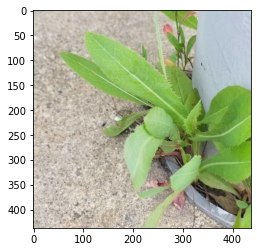

In [2]:
plt.imshow(imageio.imread('plantnet/images_train/1355868/01aca26dc4a0b0af7c55ecf84d8772179bf6fd6d.jpg'))
plt.show()

In [3]:
plt.imshow(imageio.imread('dataset_id/train/Cherry/0a0bd696-c093-47ef-866b-7f5a40af3edb___JR_HL 3952.JPG'))
plt.show()

In [4]:
train_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

test_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
])

In [8]:
train_dataset = datasets.ImageFolder(
    'plantnet/images_train',
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    'plantnet/images_val',
    transform=test_transform
)

In [6]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [7]:
# Define the model
model = models.densenet161(pretrained=True)

date = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
filename = f'figures/densenet_{date}'
model_name = f'models/plant_id_densenet161_3epochs_{date}.pth'

# Freeze VGG weights
for param in model.parameters():
    param.requires_grad = False

In [8]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [9]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [10]:
n_features = model.classifier.in_features
n_features

2208

In [11]:
model.classifier = nn.Linear(n_features,len(train_dataset.classes))

In [12]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device);

cuda


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
# Function to encapsulate training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backwards and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        # Evaluate the model
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
        Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [16]:
len(train_dataset.classes)

1081

In [17]:
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epochs=3,
)

Epoch 1/3, Train Loss: 2.3290,         Test Loss: 1.8887, Duration: 0:50:31.228297
Epoch 2/3, Train Loss: 1.5326,         Test Loss: 1.7196, Duration: 0:49:34.658761
Epoch 3/3, Train Loss: 1.3533,         Test Loss: 1.6963, Duration: 0:49:30.044865


In [18]:
fig, ax1 = plt.subplots()
plt.plot(train_losses, 'r', label = 'training loss', )
plt.plot(test_losses, 'g', label = 'validation loss' )
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.show()

fig.savefig(filename, bbox_inches='tight')

In [19]:
# Accuracy
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    
    # Get predictions
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs,1)
    
    # Update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    
    # Get predictions
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs,1)
    
    # Update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')
# ResNet has 43.71% test accuracy (partial dataset)
# DenseNet 56% (whole dataset)
# VGG19 41% whole set 
# InceptionV3 49.6%

#DenseNet 69% train acc, 63% test acc [01/03/2022]
#DenseNet 70% train acc, 64% test acc [20/03/2022]
#ResNet 55% train acc, 53% test acc [20/03/2022]
#InceptionV3 54% train acc, 50% test acc [21/03/2022]

Train acc: 0.6930, Test acc: 0.6305


In [20]:
# torch.save(model.state_dict(), f"models/plant_id_densenet_3epochs_64perc_testacc_{date}.pth")

In [28]:
# from sklearn.metrics import confusion_matrix, classification_report
# import itertools

In [30]:
# # Confusion matrix
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
    
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
        
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

In [31]:
# get all predictions in an array and plot confusion matrix

# x_test = test_dataset
# y_test = np.array(test_dataset.targets)
# p_test = np.array([])
# for inputs, targets in test_loader:  
#     # Move to GPU
#     inputs, targets = inputs.to(device), targets.to(device)

#     # Forward pass
#     outputs = model(inputs)

#     # Get prediction
#     _, predictions = torch.max(outputs, 1)
  
#     # update p_test
#     p_test = np.concatenate((p_test, predictions.cpu().numpy()))

# cm = confusion_matrix(y_test, p_test)
# plot_confusion_matrix(cm, list(range(50)))